## Module

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
import urllib.request

urllib.request.urlretrieve('https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv', filename='spam.csv')
data = pd.read_csv('spam.csv', encoding='latin-1')
print(len(data))

5572


In [19]:
data[:10]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [20]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham', 'spam'], [0,1])
data[:10]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [21]:
data.drop_duplicates(subset=['v2'], inplace=True)

In [22]:
len(data)

5169

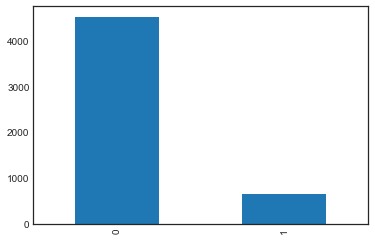

In [23]:
data['v1'].value_counts().plot(kind='bar')
plt.show()

In [24]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [25]:
X_data = data['v2']
y_data = data['v1']

In [26]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_data)
sequences = tokenizer.texts_to_sequences(X_data)

In [27]:
sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [30]:
X_data = sequences

print('메일 최대 길이 : {}'.format(max(len(l) for l in X_data)))
print('메일 평균 길이 : {}'.format((sum(map(len, X_data))/len(data))))

메일 최대 길이 : 172
메일 평균 길이 : 12.566840781582512


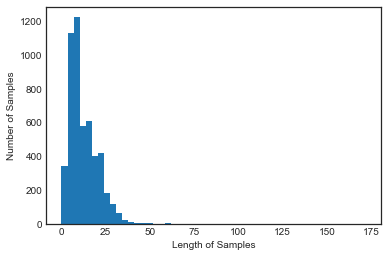

In [31]:
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [33]:
max_len = 60
data = pad_sequences(X_data, maxlen = max_len)
print(data.shape)

(5169, 60)


In [34]:
n_train = int(len(sequences)*0.8)
n_test = int(len(sequences) - n_train)

print(n_train)
print(n_test)

4135
1034


In [35]:
X_train = data[:n_train]
y_train = np.array(y_data[:n_train])
X_test = data[n_train:]
y_test = np.array(y_data[n_train:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


## Modeling

In [37]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [38]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [39]:
history = model.fit(X_train, y_train,
                   epochs=10,
                   batch_size=64,
                   validation_split=0.2,
                   callbacks=[es, mc])

Epoch 1/10
38/52 [====================>.........] - ETA: 0s - loss: 0.5171 - acc: 0.8590
Epoch 00001: val_acc improved from -inf to 0.87304, saving model to best_model.h5
52/52 [==============================] - 1s 6ms/step - loss: 0.4792 - acc: 0.8646 - val_loss: 0.3782 - val_acc: 0.8730
Epoch 2/10
40/52 [======================>.......] - ETA: 0s - loss: 0.3886 - acc: 0.8648
Epoch 00002: val_acc did not improve from 0.87304
52/52 [==============================] - 0s 3ms/step - loss: 0.3738 - acc: 0.8697 - val_loss: 0.3214 - val_acc: 0.8730
Epoch 3/10
42/52 [=======================>......] - ETA: 0s - loss: 0.2236 - acc: 0.9055
Epoch 00003: val_acc improved from 0.87304 to 0.97703, saving model to best_model.h5
52/52 [==============================] - 0s 3ms/step - loss: 0.2039 - acc: 0.9184 - val_loss: 0.0943 - val_acc: 0.9770
Epoch 4/10
40/52 [======================>.......] - ETA: 0s - loss: 0.0717 - acc: 0.9836
Epoch 00004: val_acc improved from 0.97703 to 0.98186, saving model to

In [40]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 794us/step - loss: 0.0610 - acc: 0.9807


[0.06104695051908493, 0.9806576371192932]